# Mel Spectrograms: Theory, Mathematics, and Implementation

## Introduction

**Mel Spectrograms** are arguably the most important audio feature for training Deep Learning models. While standard spectrograms are useful, they don't represent sound the way humans perceive it. To build better AI for audio, we need a representation that mimics the human ear.

### Why Mel Spectrograms?

- **Better for Deep Learning**: Mel Spectrograms often lead to better performance in tasks like:
  - Genre Classification
  - Automatic Speech Recognition (ASR)
  - Emotion Recognition
  - Music Information Retrieval (MIR)

- **Human-Centric Representation**: They represent audio the way humans hear it, highlighting features that matter most for perception.

### The Problem with Standard Spectrograms

Standard spectrograms use a **linear frequency scale**:
- The distance between 100 Hz and 200 Hz is visually the same as between 1000 Hz and 1100 Hz
- But humans don't hear frequencies linearly - we hear them **logarithmically**

**Example of Human Perception:**
- 100 Hz → 200 Hz (100 Hz difference): Sounds like a HUGE pitch change (one octave)
- 1000 Hz → 1100 Hz (100 Hz difference): Sounds like a SMALL pitch change

At lower frequencies, we can distinguish pitch changes very well. At higher frequencies, we need a much larger change in frequency to perceive the same change in pitch.

In [17]:
# Import required libraries
from google.colab import files
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile  # Add this import
import io
import urllib.request

import pandas as pd

# Set plot style
plt.style.use('default')
%matplotlib inline

## 1. Loading Audio Files

In [12]:
def load_audio_from_url(url):
    """Load audio directly from URL without saving to disk"""
    try:
        print(f"Streaming audio from URL...")
        # Download to memory
        with urllib.request.urlopen(url) as response:
            audio_data = response.read()
        
        # Create a file-like object in memory
        audio_file = io.BytesIO(audio_data)
        
        # Read WAV file from memory
        sample_rate, audio_array = wavfile.read(audio_file)
        
        # Convert to mono if stereo
        if len(audio_array.shape) > 1:
            audio_array = audio_array.mean(axis=1)
        
        # Normalize
        audio_array = audio_array.astype(float)
        if np.max(np.abs(audio_array)) > 0:
            audio_array = audio_array / np.max(np.abs(audio_array))
        
        print(f"✓ Loaded audio: {len(audio_array)} samples at {sample_rate} Hz")
        return audio_array, sample_rate
        
    except Exception as e:
        print(f"✗ Failed to load audio: {e}")
        return None, None

# Try to load audio from online source
print("="*70)
print("AUDIO LOADING (NO FILES SAVED)")
print("="*70)

# Try multiple sources
audio_urls = [
    'https://www.kozco.com/tech/organfinale.wav',
    'https://www.kozco.com/tech/piano2.wav',
    'https://www.kozco.com/tech/audacity/1.wav',
    'https://www.kozco.com/tech/audacity/1a.wav',
]

# Collect multiple audio files
audio_files = []  # List to store (audio_data, sample_rate, url) tuples

for url in audio_urls:
    audio_data, sample_rate = load_audio_from_url(url)
    if audio_data is not None:
        audio_files.append({
            'data': audio_data,
            'sample_rate': sample_rate,
            'url': url,
            'name': url.split('/')[-1]  # Extract filename from URL
        })
        print(f"✓ Added to collection: {url.split('/')[-1]}")

print(f"\n{'='*70}")
print(f"Successfully loaded {len(audio_files)} audio file(s)")
print(f"{'='*70}")


# load audio files with librosa
scale, sr = audio_files[0]['data'], audio_files[0]['sample_rate']
debussy, _ = audio_files[1]['data'], audio_files[1]['sample_rate']
redhot, _ = audio_files[2]['data'], audio_files[2]['sample_rate']
duke, _ = audio_files[3]['data'], audio_files[3]['sample_rate']

AUDIO LOADING (NO FILES SAVED)
Streaming audio from URL...


/tmp/ipython-input-59763130.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_array = wavfile.read(audio_file)


✓ Loaded audio: 573378 samples at 44100 Hz
✓ Added to collection: organfinale.wav
Streaming audio from URL...
✓ Loaded audio: 302712 samples at 48000 Hz
✓ Added to collection: piano2.wav
Streaming audio from URL...
✓ Loaded audio: 1332529 samples at 44100 Hz
✓ Added to collection: 1.wav
Streaming audio from URL...
✓ Loaded audio: 1332578 samples at 44100 Hz
✓ Added to collection: 1a.wav

Successfully loaded 4 audio file(s)


## 2. Theory: The Mel Scale

### What is the Mel Scale?

The **Mel scale** is a perceptual scale of pitches judged by listeners to be equal in distance from one another. It was named after the word "melody" to indicate that the scale is based on pitch comparisons.

### The Mathematics

#### Converting Hertz to Mels

$$m = 2595 \cdot \log_{10}\left(1 + \frac{f}{700}\right)$$

Where:
- $m$ = frequency in Mels
- $f$ = frequency in Hertz (Hz)

#### Converting Mels back to Hertz

$$f = 700 \cdot \left(10^{m/2595} - 1\right)$$

### Key Properties

1. **Logarithmic relationship**: The Mel scale is approximately logarithmic above 1000 Hz
2. **Linear below 1000 Hz**: Below 1000 Hz, the relationship is nearly linear
3. **Perceptually uniform**: Equal distances on the Mel scale correspond to equal perceived pitch differences

In [14]:
# Define conversion functions
def hz_to_mel(f):
    """Convert frequency in Hz to Mel scale"""
    return 2595 * np.log10(1 + f / 700)

def mel_to_hz(m):
    """Convert Mel scale to frequency in Hz"""
    return 700 * (10**(m / 2595) - 1)

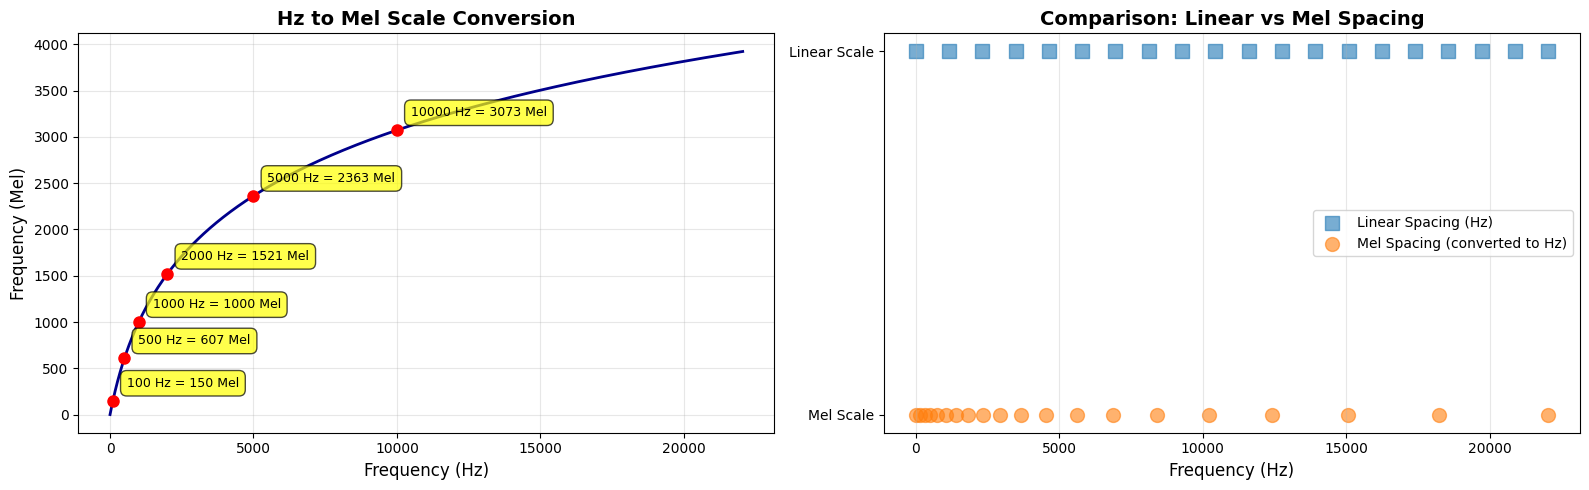

Observation:
- Linear spacing: Points are equally distributed across the frequency range
- Mel spacing: Points are dense at low frequencies, sparse at high frequencies
- This matches human hearing: we're more sensitive to changes at low frequencies!


In [15]:
# Visualize the Mel scale transformation
frequencies_hz = np.linspace(0, sr/2, 1000)
frequencies_mel = hz_to_mel(frequencies_hz)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Hz to Mel conversion
axes[0].plot(frequencies_hz, frequencies_mel, linewidth=2, color='darkblue')
axes[0].set_xlabel('Frequency (Hz)', fontsize=12)
axes[0].set_ylabel('Frequency (Mel)', fontsize=12)
axes[0].set_title('Hz to Mel Scale Conversion', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Annotate key points
key_freqs = [100, 500, 1000, 2000, 5000, 10000]
for f in key_freqs:
    if f <= sr/2:
        m = hz_to_mel(f)
        axes[0].plot(f, m, 'ro', markersize=8)
        axes[0].annotate(f'{f} Hz = {m:.0f} Mel', 
                        xy=(f, m), xytext=(10, 10),
                        textcoords='offset points', fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Plot 2: Comparison of spacing
linear_spacing = np.linspace(0, sr/2, 20)
mel_spacing_hz = mel_to_hz(np.linspace(0, hz_to_mel(sr/2), 20))

axes[1].scatter(linear_spacing, np.ones_like(linear_spacing), 
               s=100, alpha=0.6, label='Linear Spacing (Hz)', marker='s')
axes[1].scatter(mel_spacing_hz, np.ones_like(mel_spacing_hz) * 0.5, 
               s=100, alpha=0.6, label='Mel Spacing (converted to Hz)', marker='o')
axes[1].set_xlabel('Frequency (Hz)', fontsize=12)
axes[1].set_yticks([0.5, 1.0])
axes[1].set_yticklabels(['Mel Scale', 'Linear Scale'])
axes[1].set_title('Comparison: Linear vs Mel Spacing', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Observation:")
print("- Linear spacing: Points are equally distributed across the frequency range")
print("- Mel spacing: Points are dense at low frequencies, sparse at high frequencies")
print("- This matches human hearing: we're more sensitive to changes at low frequencies!")

### Understanding the Transformation

Let's see how different frequency ranges map to the Mel scale:

In [18]:
# Create a comparison table
freq_ranges = [
    (100, 200, "Low frequency range"),
    (1000, 1100, "Mid frequency range"),
    (5000, 5100, "High frequency range"),
    (10000, 10100, "Very high frequency range")
]

data = []
for f1, f2, desc in freq_ranges:
    m1 = hz_to_mel(f1)
    m2 = hz_to_mel(f2)
    hz_diff = f2 - f1
    mel_diff = m2 - m1
    data.append({
        'Description': desc,
        'Hz Range': f"{f1}-{f2} Hz",
        'Hz Difference': f"{hz_diff} Hz",
        'Mel Range': f"{m1:.1f}-{m2:.1f} Mel",
        'Mel Difference': f"{mel_diff:.2f} Mel",
        'Perceptual Impact': 'High' if mel_diff > 10 else 'Medium' if mel_diff > 5 else 'Low'
    })

df = pd.DataFrame(data)
print("Frequency to Mel Conversion Comparison:")
print("="*80)
print(df.to_string(index=False))
print("="*80)
print("Key Insight:")
print("Even though all ranges have the same 100 Hz difference,")
print("the Mel difference (and thus perceptual impact) decreases at higher frequencies!")

Frequency to Mel Conversion Comparison:
              Description       Hz Range Hz Difference         Mel Range Mel Difference Perceptual Impact
      Low frequency range     100-200 Hz        100 Hz   150.5-283.2 Mel     132.74 Mel              High
      Mid frequency range   1000-1100 Hz        100 Hz 1000.0-1064.4 Mel      64.42 Mel              High
     High frequency range   5000-5100 Hz        100 Hz 2363.5-2383.1 Mel      19.60 Mel              High
Very high frequency range 10000-10100 Hz        100 Hz 3073.2-3083.7 Mel      10.48 Mel              High
Key Insight:
Even though all ranges have the same 100 Hz difference,
the Mel difference (and thus perceptual impact) decreases at higher frequencies!


## 3. Creating Mel Spectrograms: The Process

Creating a Mel Spectrogram involves 4 main steps:

1. **Compute STFT** (Short-Time Fourier Transform)
2. **Construct Mel Filter Banks** (triangular filters)
3. **Apply Filter Banks** to the spectrogram (matrix multiplication)
4. **Convert to Log Scale** (Decibels)

### Step 1: Compute STFT

In [19]:
# Parameters
FRAME_SIZE = 2048
HOP_SIZE = 512

# Compute STFT
S_scale = librosa.stft(scale, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
Y_scale = np.abs(S_scale) ** 2

print(f"STFT Output Shape: {S_scale.shape}")
print(f"Power Spectrogram Shape: {Y_scale.shape}")

STFT Output Shape: (1025, 1120)
Power Spectrogram Shape: (1025, 1120)


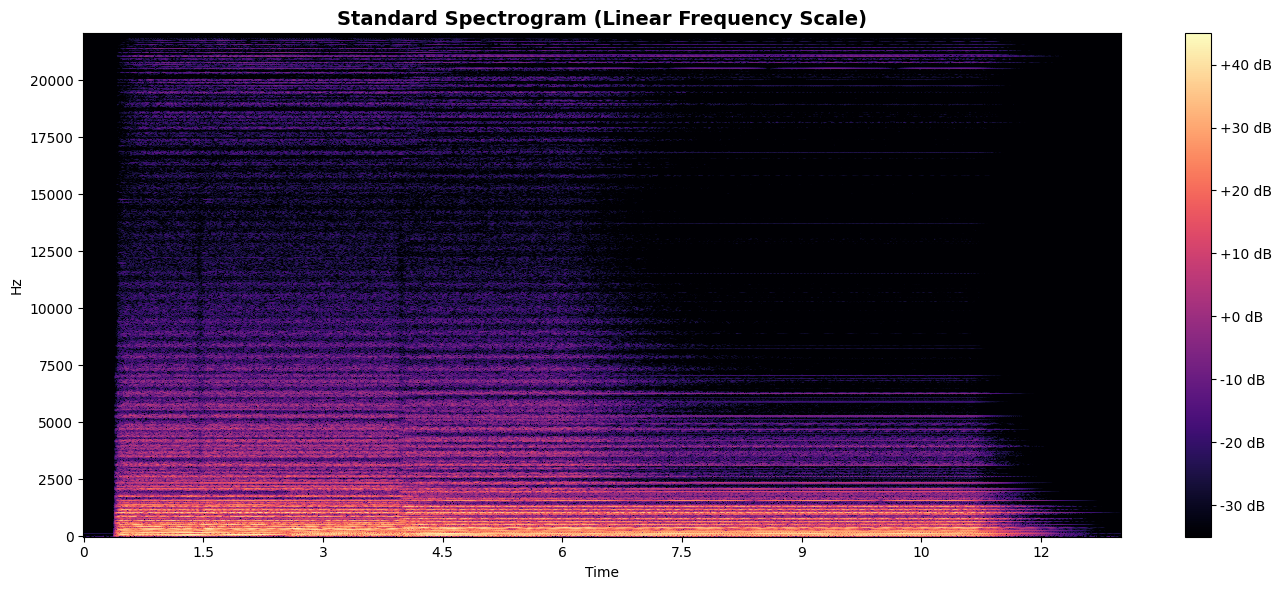

In [20]:
# Visualize standard spectrogram
Y_log_scale = librosa.power_to_db(Y_scale)

plt.figure(figsize=(14, 6))
librosa.display.specshow(Y_log_scale, sr=sr, hop_length=HOP_SIZE, 
                         x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Standard Spectrogram (Linear Frequency Scale)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Mel Filter Banks - Mathematical Construction

### Building Filter Banks from Scratch

In [21]:
def create_mel_filterbank(sr, n_fft, n_mels=128, fmin=0.0, fmax=None):
    if fmax is None:
        fmax = sr / 2.0
    
    # Convert to Mel scale
    mel_min = hz_to_mel(fmin)
    mel_max = hz_to_mel(fmax)
    
    # Create equally spaced points in Mel space
    mel_points = np.linspace(mel_min, mel_max, n_mels + 2)
    
    # Convert back to Hz
    hz_points = mel_to_hz(mel_points)
    
    # Convert Hz to FFT bin numbers
    fft_bins = np.floor((n_fft + 1) * hz_points / sr).astype(int)
    
    # Create triangular filters
    filterbank = np.zeros((n_mels, n_fft // 2 + 1))
    
    for m in range(n_mels):
        left = fft_bins[m]
        center = fft_bins[m + 1]
        right = fft_bins[m + 2]
        
        # Rising slope
        for k in range(left, center):
            filterbank[m, k] = (k - left) / (center - left)
        
        # Falling slope
        for k in range(center, right):
            filterbank[m, k] = (right - k) / (right - center)
    
    return filterbank, hz_points, fft_bins

# Create filter bank
n_mels = 10
mel_filterbank, hz_points, fft_bins = create_mel_filterbank(sr, FRAME_SIZE, n_mels=n_mels)
print(f"Filter bank shape: {mel_filterbank.shape}")

Filter bank shape: (10, 1025)


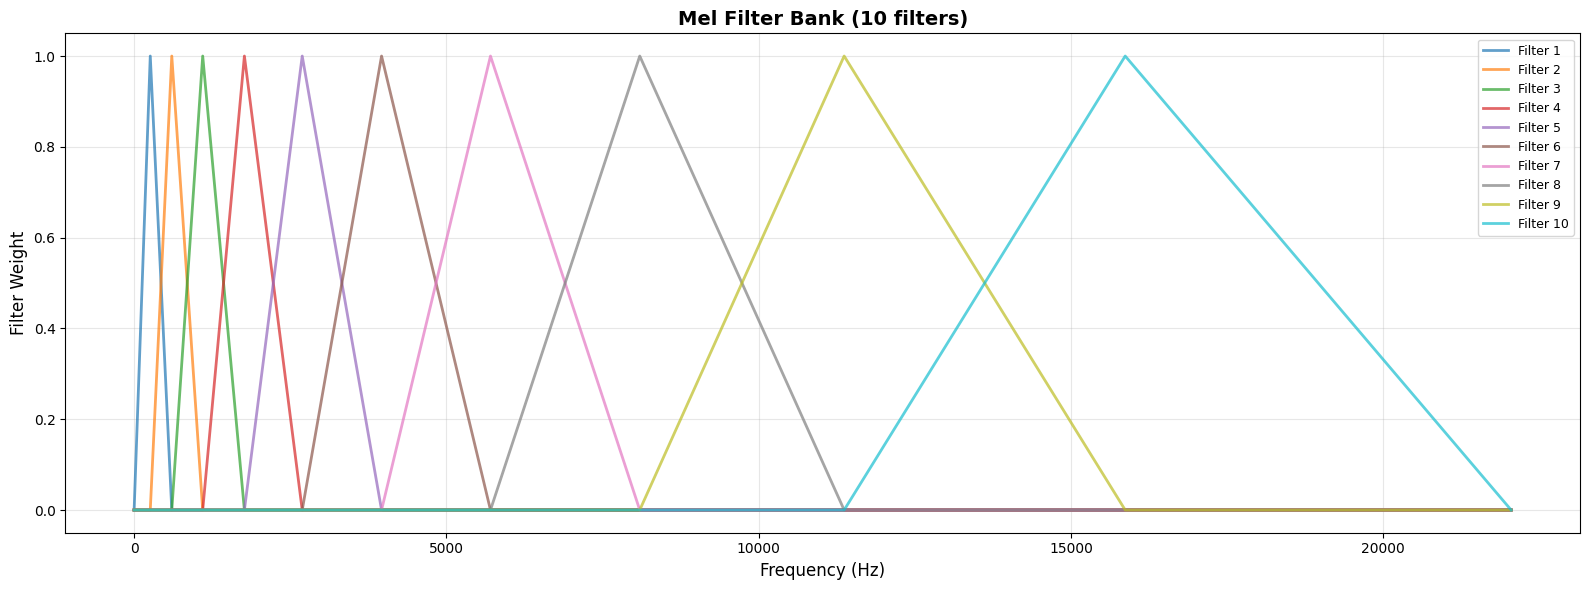

Observations:
1. Filters are TRIANGULAR
2. Filters OVERLAP
3. Filters are NARROW at low frequencies
4. Filters are WIDE at high frequencies


In [22]:
# Visualize filter bank
fft_freqs = librosa.fft_frequencies(sr=sr, n_fft=FRAME_SIZE)

plt.figure(figsize=(16, 6))
for i in range(n_mels):
    plt.plot(fft_freqs, mel_filterbank[i], linewidth=2, alpha=0.7, label=f'Filter {i+1}')

plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Filter Weight', fontsize=12)
plt.title(f'Mel Filter Bank ({n_mels} filters)', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Observations:")
print("1. Filters are TRIANGULAR")
print("2. Filters OVERLAP")
print("3. Filters are NARROW at low frequencies")
print("4. Filters are WIDE at high frequencies")

## 5. Practical Implementation with Librosa

In [23]:
# Extract Mel Spectrogram using librosa
n_mels_full = 128

mel_spec = librosa.feature.melspectrogram(
    y=scale,
    sr=sr,
    n_fft=FRAME_SIZE,
    hop_length=HOP_SIZE,
    n_mels=n_mels_full
)

mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

print(f"Mel Spectrogram shape: {mel_spec.shape}")
print(f"Value range (dB): [{mel_spec_db.min():.2f}, {mel_spec_db.max():.2f}] dB")

Mel Spectrogram shape: (128, 1120)
Value range (dB): [-80.00, 0.00] dB


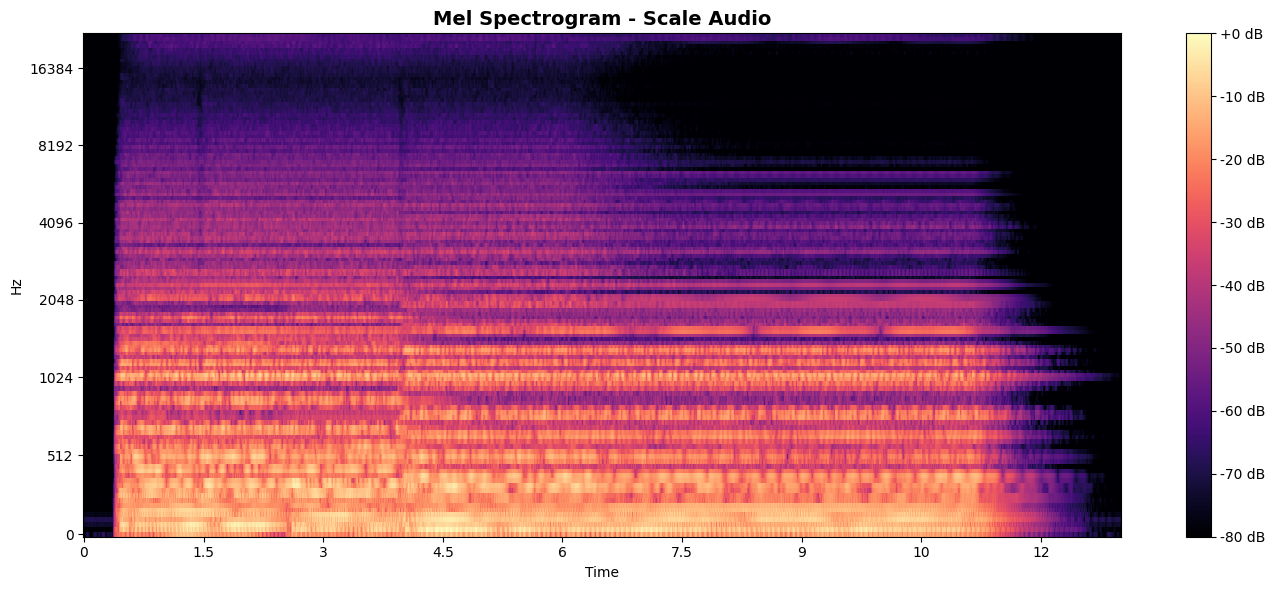

In [24]:
# Plot Mel spectrogram
plt.figure(figsize=(14, 6))
librosa.display.specshow(
    mel_spec_db,
    sr=sr,
    hop_length=HOP_SIZE,
    x_axis='time',
    y_axis='mel',
    cmap='magma'
)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram - Scale Audio', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Comparison: Standard vs Mel Spectrogram

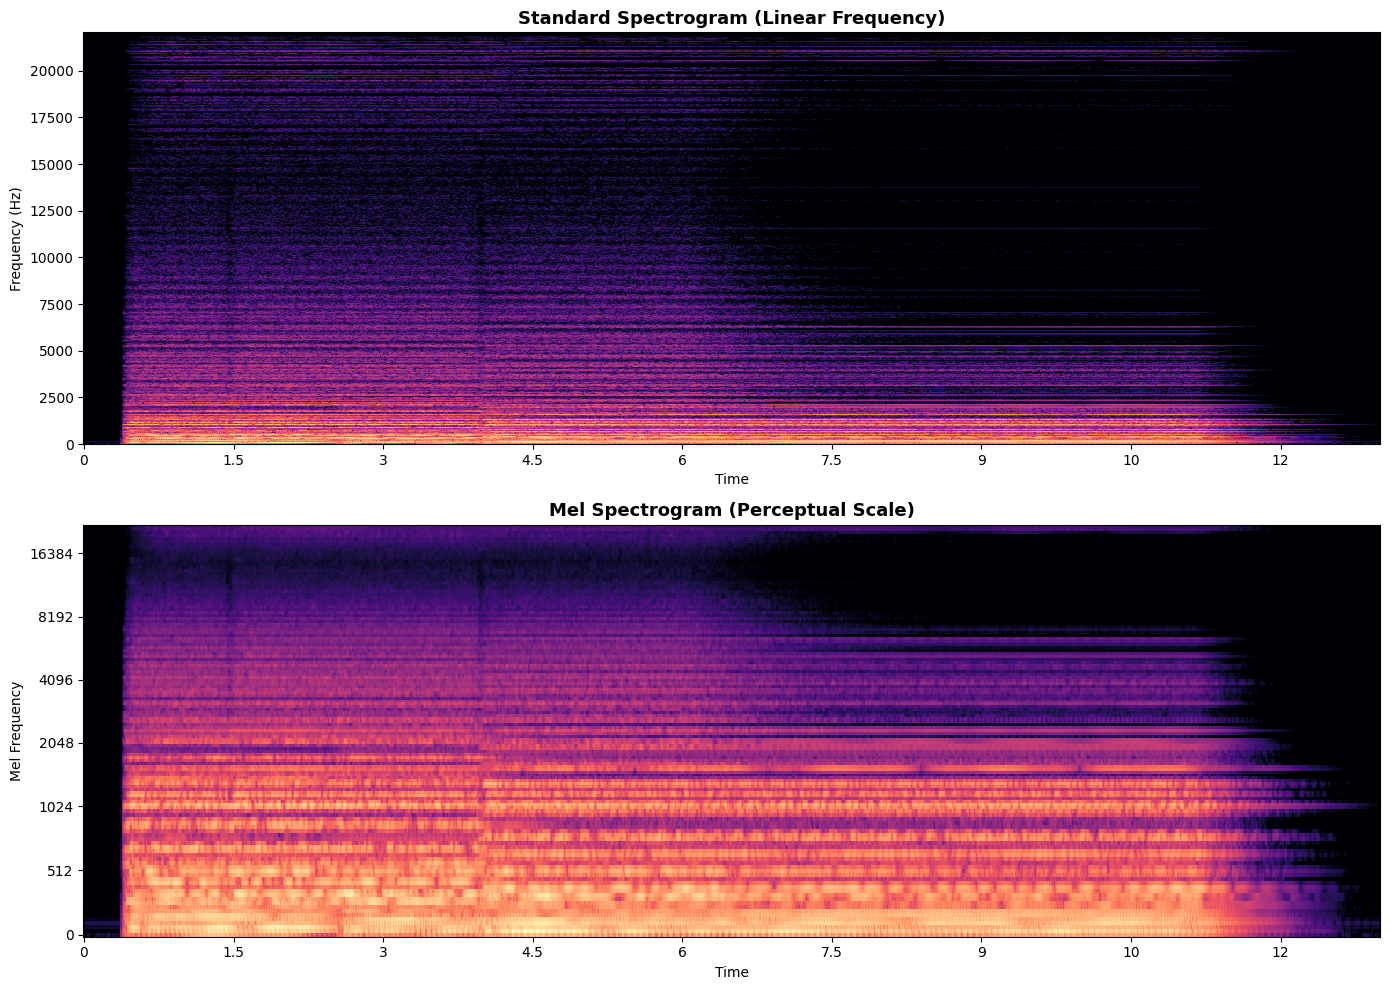

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Standard Spectrogram
librosa.display.specshow(Y_log_scale, sr=sr, hop_length=HOP_SIZE,
                         x_axis='time', y_axis='hz', cmap='magma', ax=axes[0])
axes[0].set_title('Standard Spectrogram (Linear Frequency)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Frequency (Hz)')

# Mel Spectrogram
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=HOP_SIZE,
                         x_axis='time', y_axis='mel', cmap='magma', ax=axes[1])
axes[1].set_title('Mel Spectrogram (Perceptual Scale)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Mel Frequency')

plt.tight_layout()
plt.show()

## 7. Comparing Different Audio Genres

In [26]:
# Extract Mel spectrograms for all audio files
mel_debussy = librosa.feature.melspectrogram(y=debussy, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=128)
mel_redhot = librosa.feature.melspectrogram(y=redhot, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=128)
mel_duke = librosa.feature.melspectrogram(y=duke, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=128)

mel_debussy_db = librosa.power_to_db(mel_debussy, ref=np.max)
mel_redhot_db = librosa.power_to_db(mel_redhot, ref=np.max)
mel_duke_db = librosa.power_to_db(mel_duke, ref=np.max)

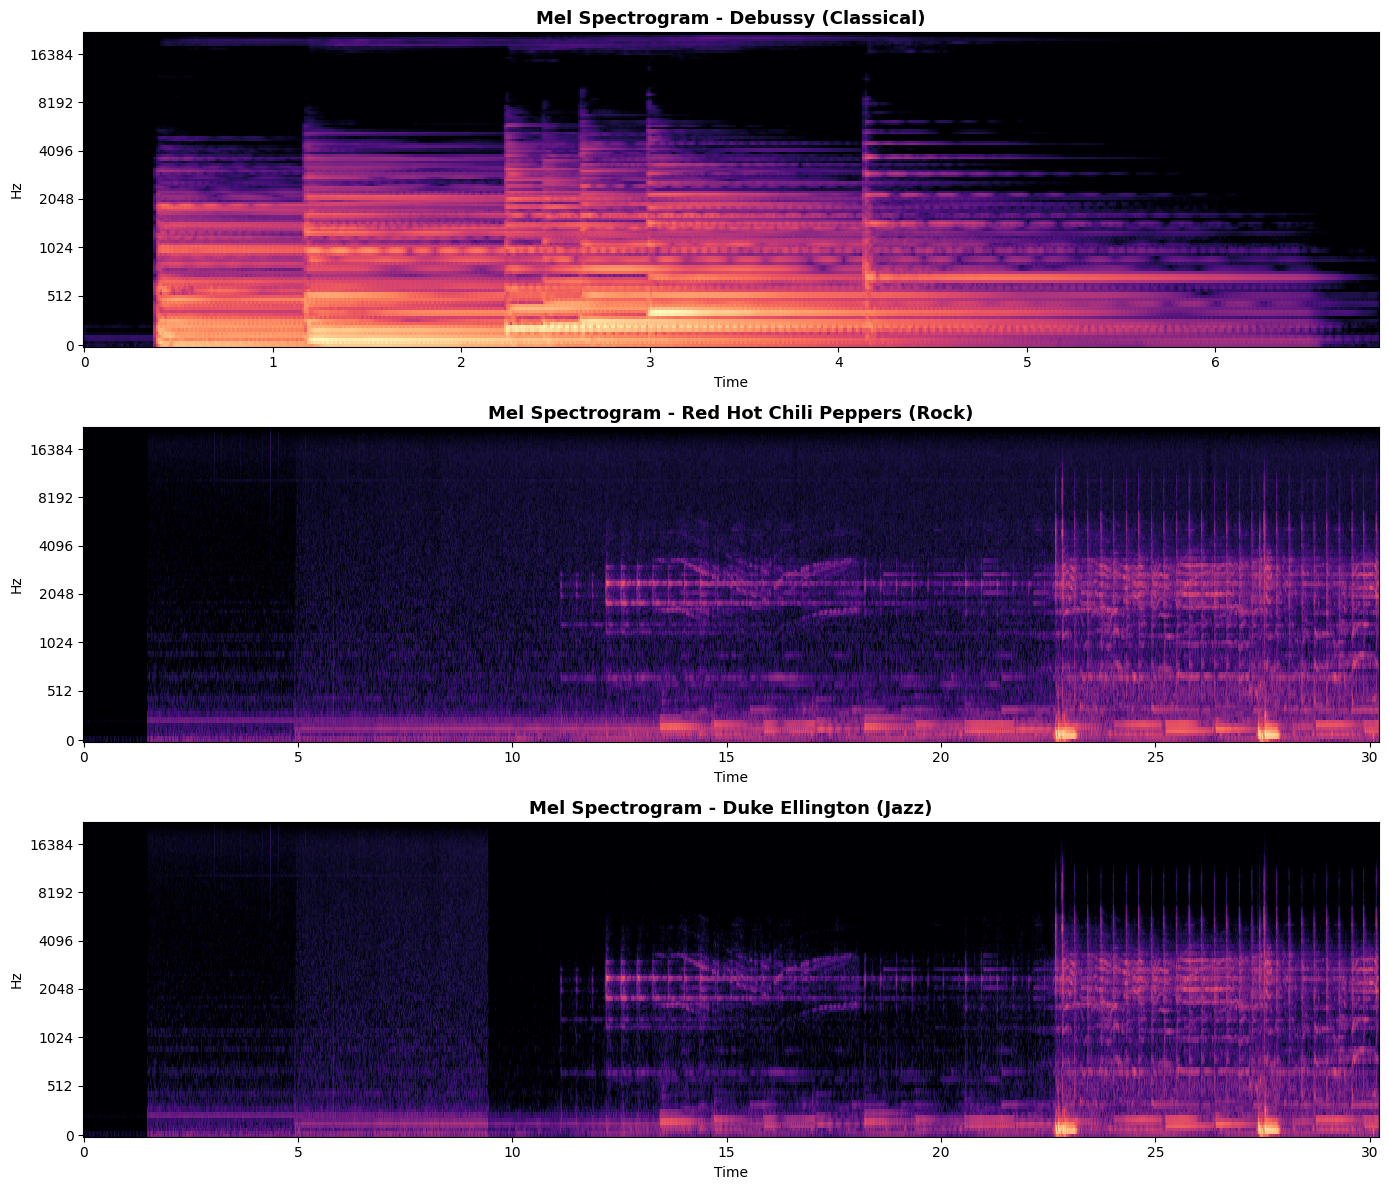

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

librosa.display.specshow(mel_debussy_db, sr=sr, hop_length=HOP_SIZE,
                         x_axis='time', y_axis='mel', cmap='magma', ax=axes[0])
axes[0].set_title('Mel Spectrogram - Debussy (Classical)', fontsize=13, fontweight='bold')

librosa.display.specshow(mel_redhot_db, sr=sr, hop_length=HOP_SIZE,
                         x_axis='time', y_axis='mel', cmap='magma', ax=axes[1])
axes[1].set_title('Mel Spectrogram - Red Hot Chili Peppers (Rock)', fontsize=13, fontweight='bold')

librosa.display.specshow(mel_duke_db, sr=sr, hop_length=HOP_SIZE,
                         x_axis='time', y_axis='mel', cmap='magma', ax=axes[2])
axes[2].set_title('Mel Spectrogram - Duke Ellington (Jazz)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Effect of Different n_mels Values

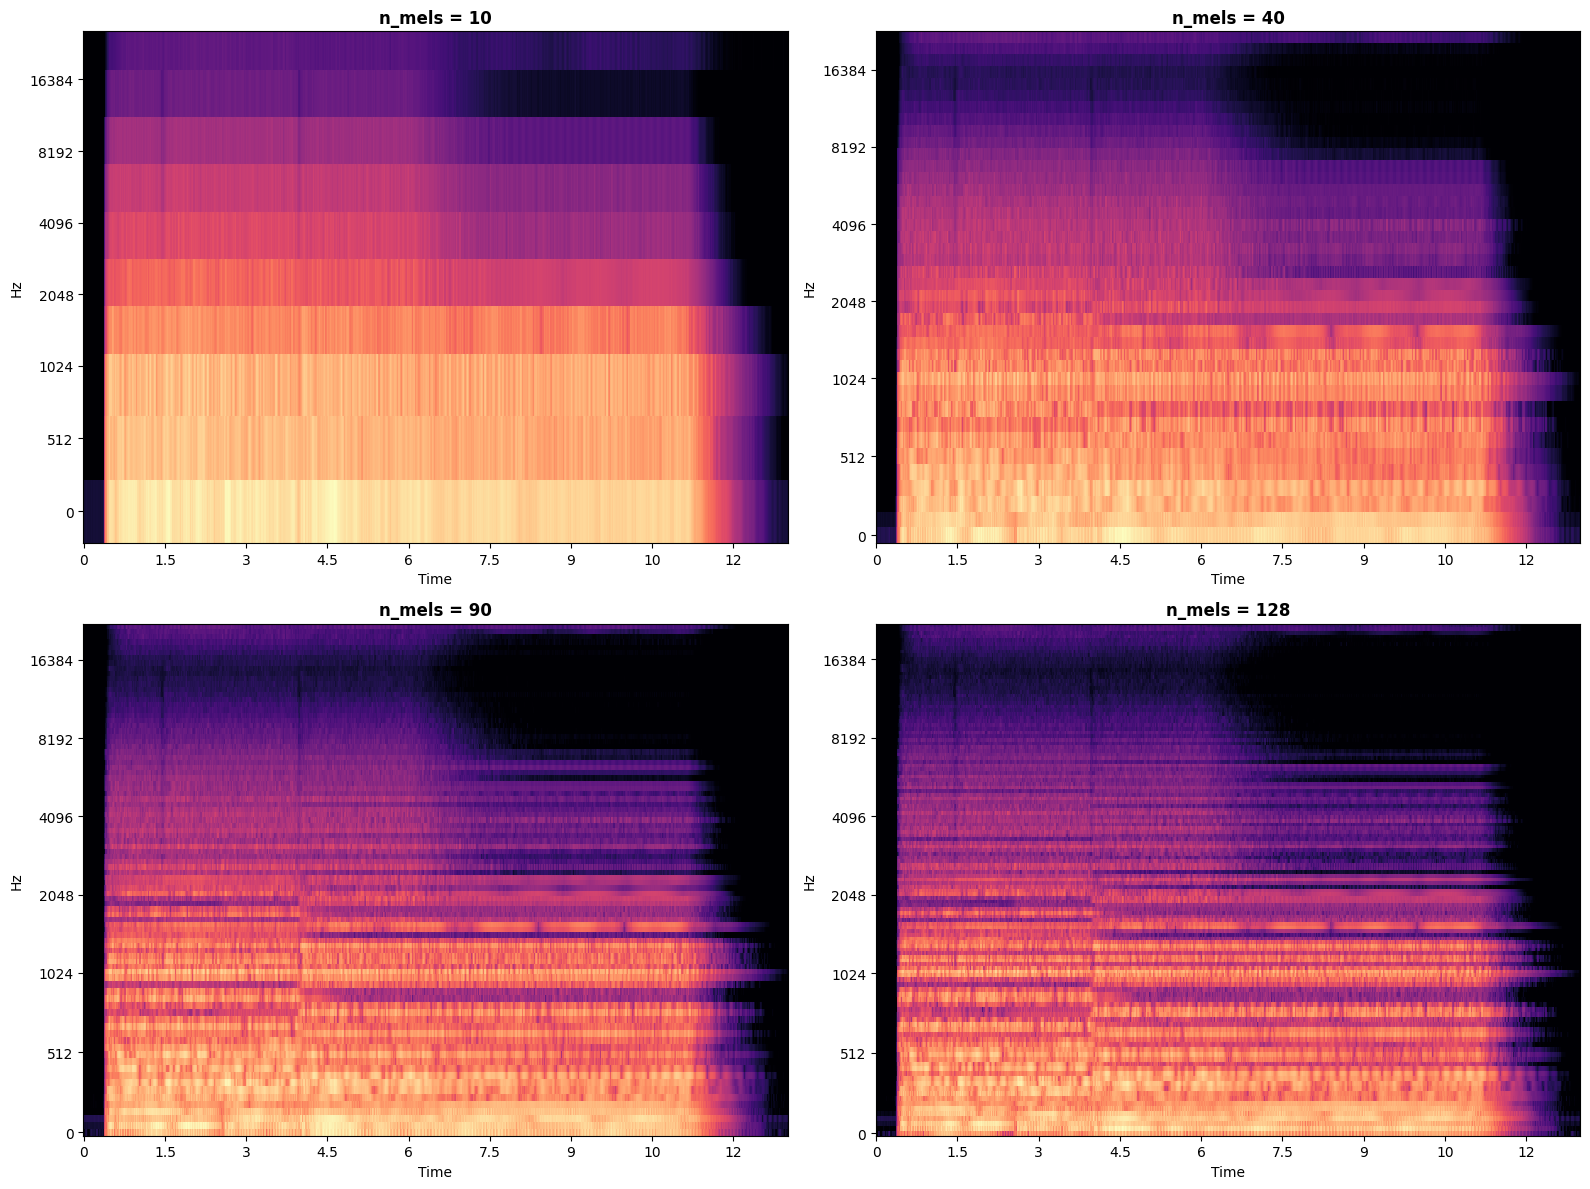

Observations:
- n_mels=10: Very coarse, blocky appearance
- n_mels=40: Better resolution, commonly used for speech
- n_mels=90: Good balance
- n_mels=128: High resolution, standard for music and deep learning


In [28]:
n_mels_values = [10, 40, 90, 128]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, n_mels_val in enumerate(n_mels_values):
    mel_spec_temp = librosa.feature.melspectrogram(
        y=scale, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=n_mels_val
    )
    mel_spec_temp_db = librosa.power_to_db(mel_spec_temp, ref=np.max)
    
    librosa.display.specshow(mel_spec_temp_db, sr=sr, hop_length=HOP_SIZE,
                             x_axis='time', y_axis='mel', cmap='magma', ax=axes[idx])
    axes[idx].set_title(f'n_mels = {n_mels_val}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("Observations:")
print("- n_mels=10: Very coarse, blocky appearance")
print("- n_mels=40: Better resolution, commonly used for speech")
print("- n_mels=90: Good balance")
print("- n_mels=128: High resolution, standard for music and deep learning")

## 9. Key Parameters Summary

### Important Parameters

| Parameter | Typical Values | Purpose |
|-----------|---------------|----------|
| `n_mels` | 40-128 | Number of Mel bands (frequency resolution) |
| `n_fft` | 2048 | FFT window size |
| `hop_length` | 512 | Step size between windows (time resolution) |
| `fmin` | 0 | Minimum frequency (Hz) |
| `fmax` | sr/2 | Maximum frequency (Hz) |

### Recommendations

- **Speech Recognition**: n_mels = 40-80
- **Music Classification**: n_mels = 128
- **General Audio**: n_mels = 128
- **Real-time Applications**: Lower n_mels for faster processing

## 10. Summary

### Key Takeaways

1. **Mel Scale**: Logarithmic frequency scale matching human perception
2. **Filter Banks**: Triangular filters that are narrow at low frequencies, wide at high frequencies
3. **Compression**: Reduces frequency bins (e.g., 1025 → 128) while preserving perceptually important information
4. **Deep Learning**: Mel Spectrograms are the standard input for audio CNNs

### Applications

- Genre Classification
- Speech Recognition
- Emotion Detection
- Music Information Retrieval
- Audio Event Detection

### Why Mel Spectrograms Work

They represent audio the way humans hear it, making them ideal for training models that need to understand audio in a human-like way.